In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from math import sqrt
from sklearn.feature_selection import SelectFromModel

In [9]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 
plt.rcParams['font.size'] = 12

In [10]:
df0 = pd.read_csv(r"Banana1_with_rot_hours.csv")
df1 = pd.read_csv(r"Banana2_with_rot_hours.csv")
df2 = pd.read_csv(r"Banana3_with_rot_hours.csv")
df3 = pd.read_csv(r"Banana4_with_rot_hours.csv")
df4 = pd.read_csv(r"Banana5_with_rot_hours.csv")

In [11]:
df0

,Hour,MQ2,MQ3,MQ4,MQ5,MQ9,MQ135,Temp,Hum,Hours Left to Rot
0,0,165,353,155,210,110,398,32.1,41.8,120
1,1,161,383,150,203,108,397,32.1,41.1,119
2,2,153,333,150,200,108,406,NAN,NAN,118
3,3,171,365,166,205,108,397,NAN,NAN,117
4,4,153,344,148,191,106,382,NAN,NAN,116
...,...,...,...,...,...,...,...,...,...,...
142,142,252,419,282,302,151,487,NAN,NAN,0
143,143,261,409,293,297,152,467,NAN,NAN,0
144,144,250,415,305,299,153,448,32.8,54.2,0
145,145,262,415,301,303,152,442,32.9,54.2,0


In [12]:
def fill_nan_values(df):
    df_filled = df.copy()
    df_filled['Temp'] = pd.to_numeric(df_filled['Temp'], errors='coerce')
    df_filled['Hum'] = pd.to_numeric(df_filled['Hum'], errors='coerce')
    
    df_filled['Temp'] = df_filled['Temp'].ffill().bfill().interpolate(method='linear').round(1)
    df_filled['Hum'] = df_filled['Hum'].ffill().bfill().interpolate(method='linear').round(1)
    return df_filled

df0 = fill_nan_values(df0)
df1 = fill_nan_values(df1)
df2 = fill_nan_values(df2)
df3 = fill_nan_values(df3)
df4 = fill_nan_values(df4)

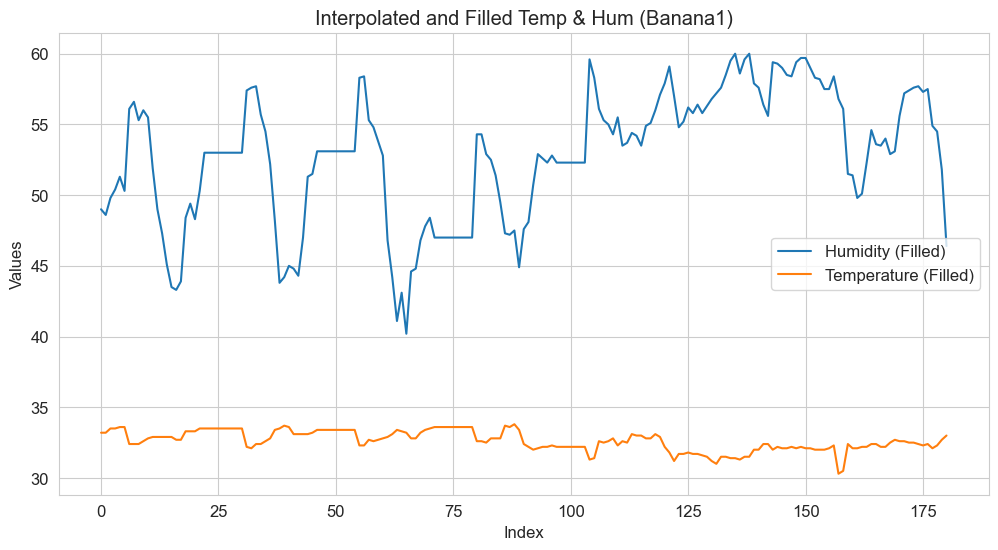

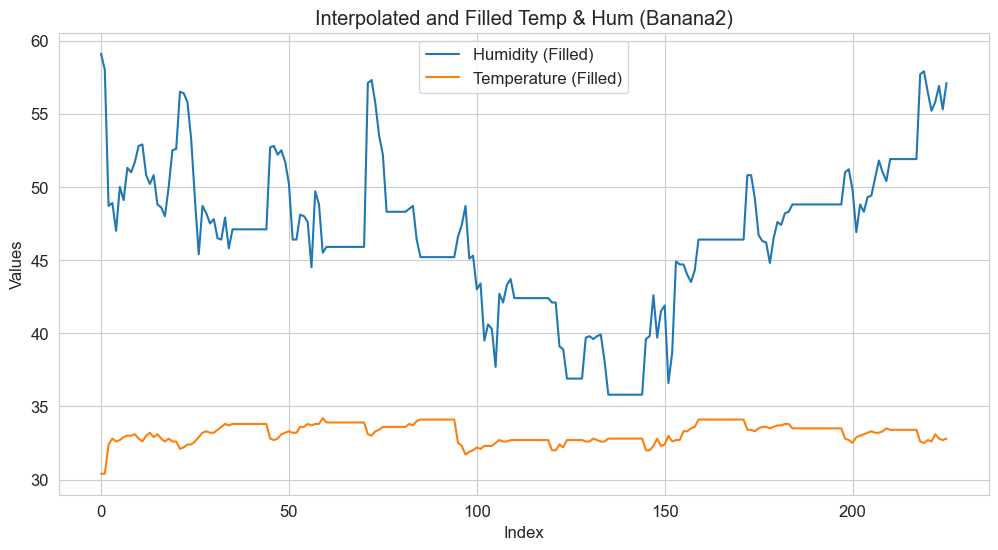

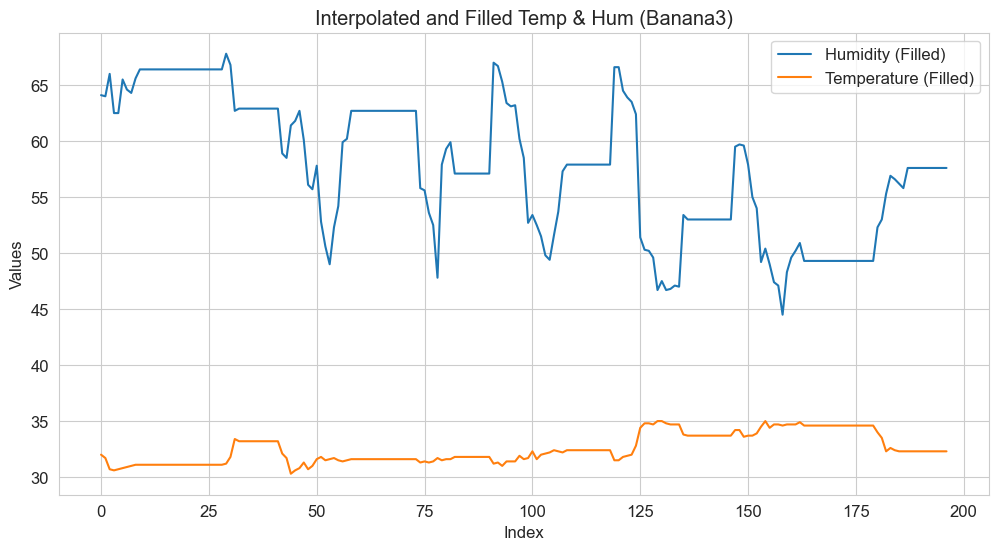

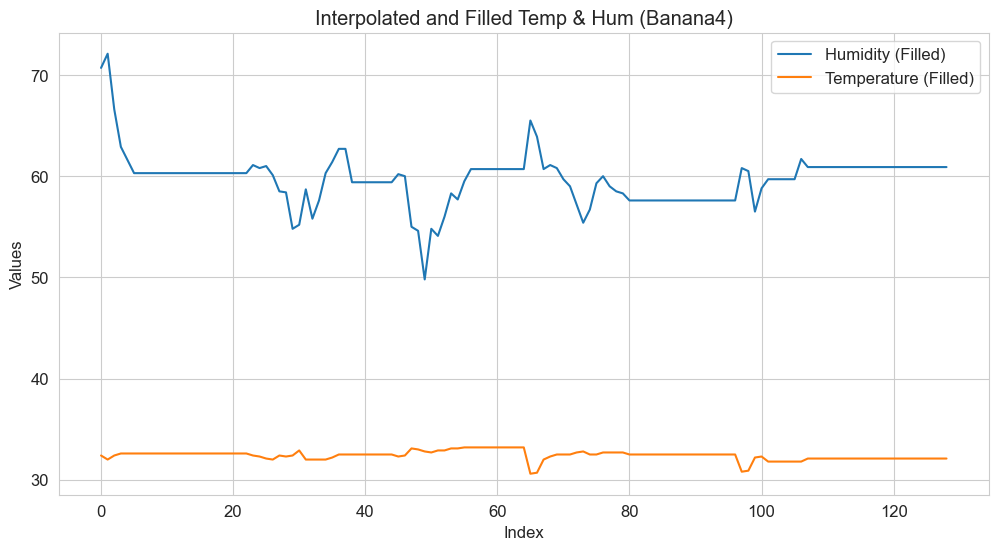

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Hour'], df1['Hum'], label='Humidity (Filled)')
plt.plot(df1['Hour'], df1['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df2['Hour'], df2['Hum'], label='Humidity (Filled)')
plt.plot(df2['Hour'], df2['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana2)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df3['Hour'], df3['Hum'], label='Humidity (Filled)')
plt.plot(df3['Hour'], df3['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana3)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df4['Hour'], df4['Hum'], label='Humidity (Filled)')
plt.plot(df4['Hour'], df4['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana4)")
plt.legend()
plt.grid(True)
plt.show()


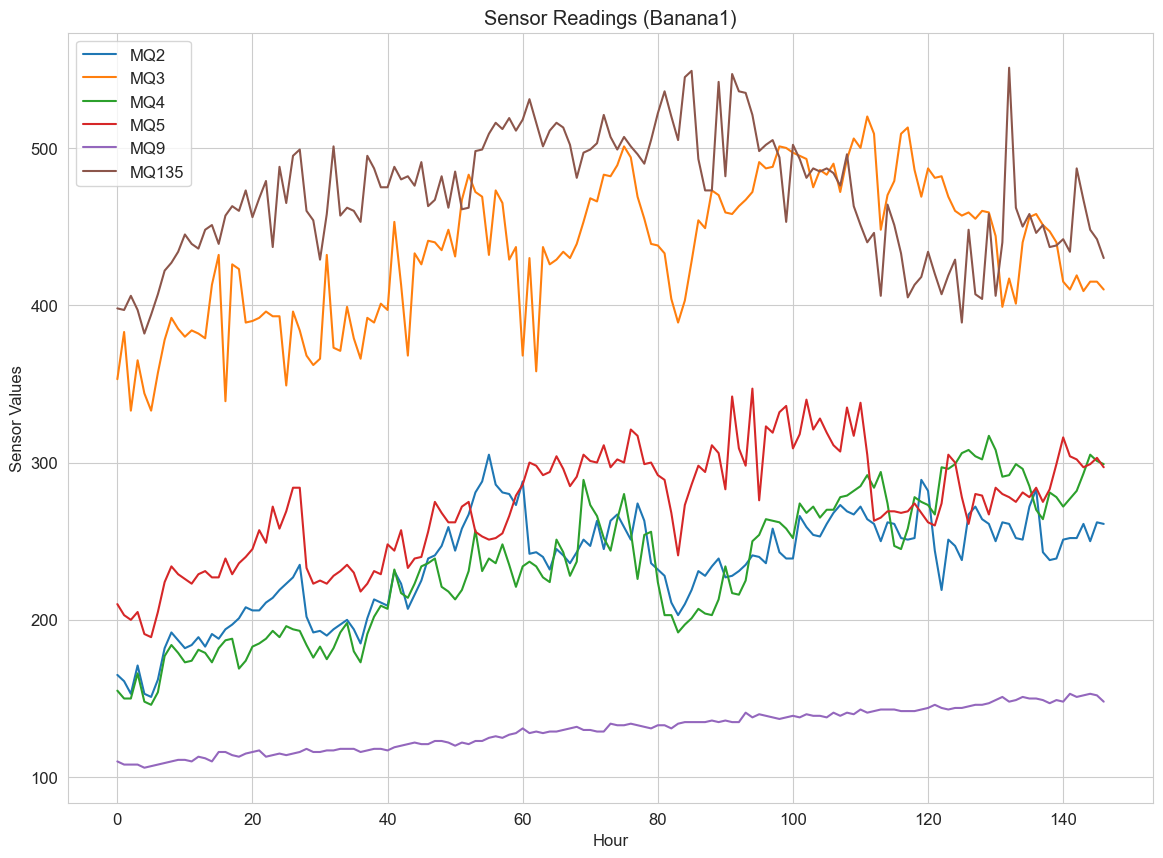

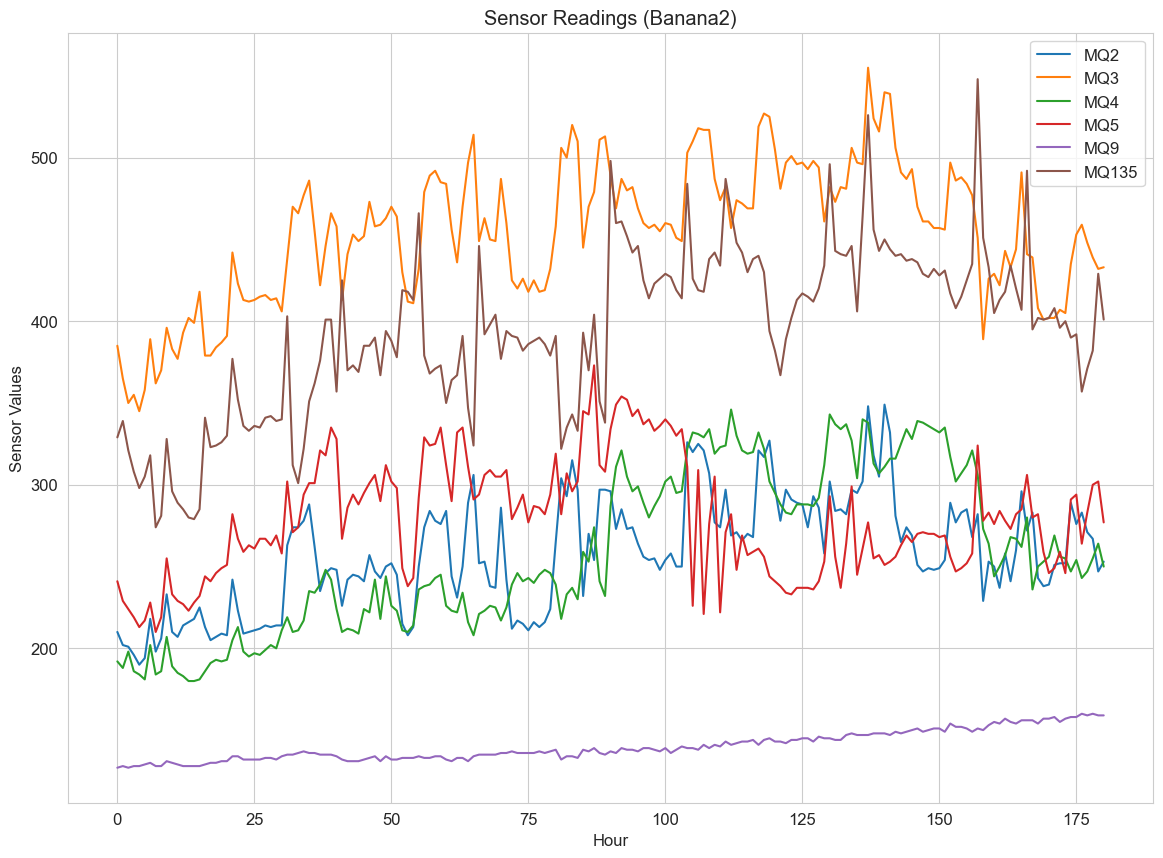

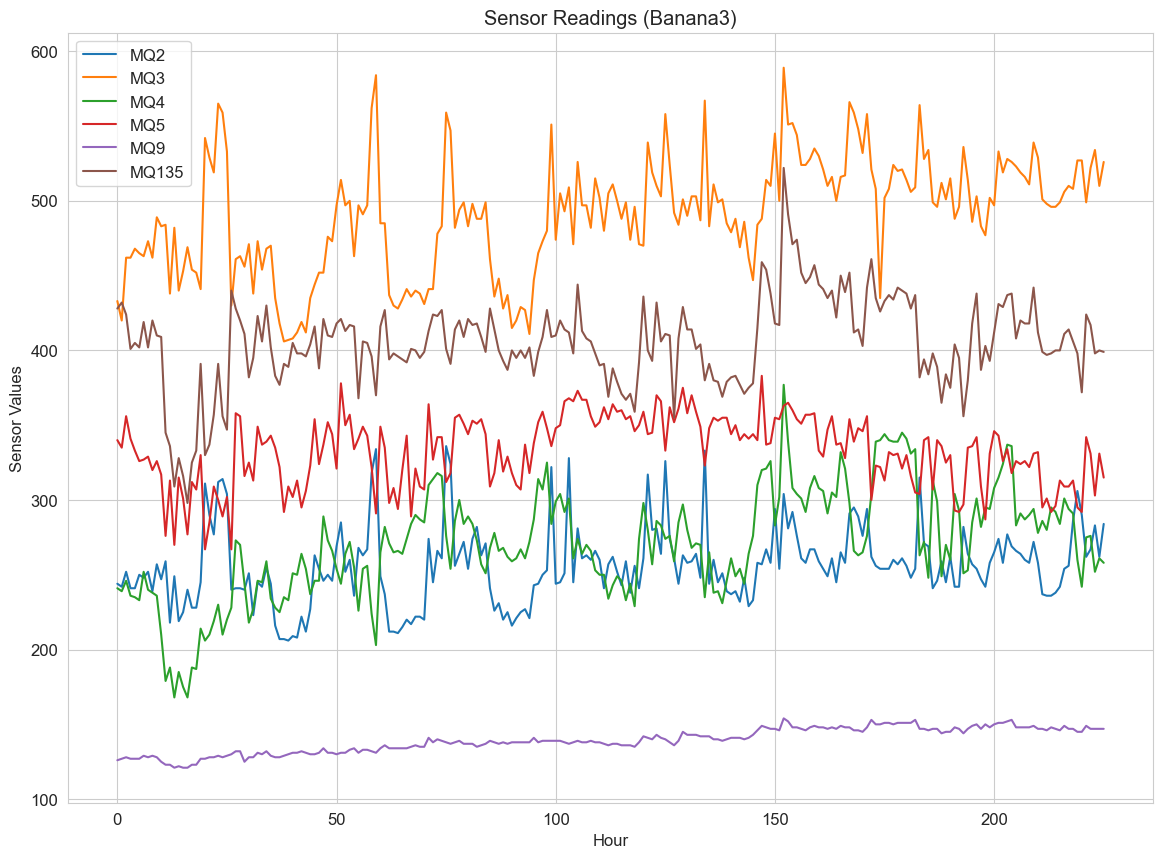

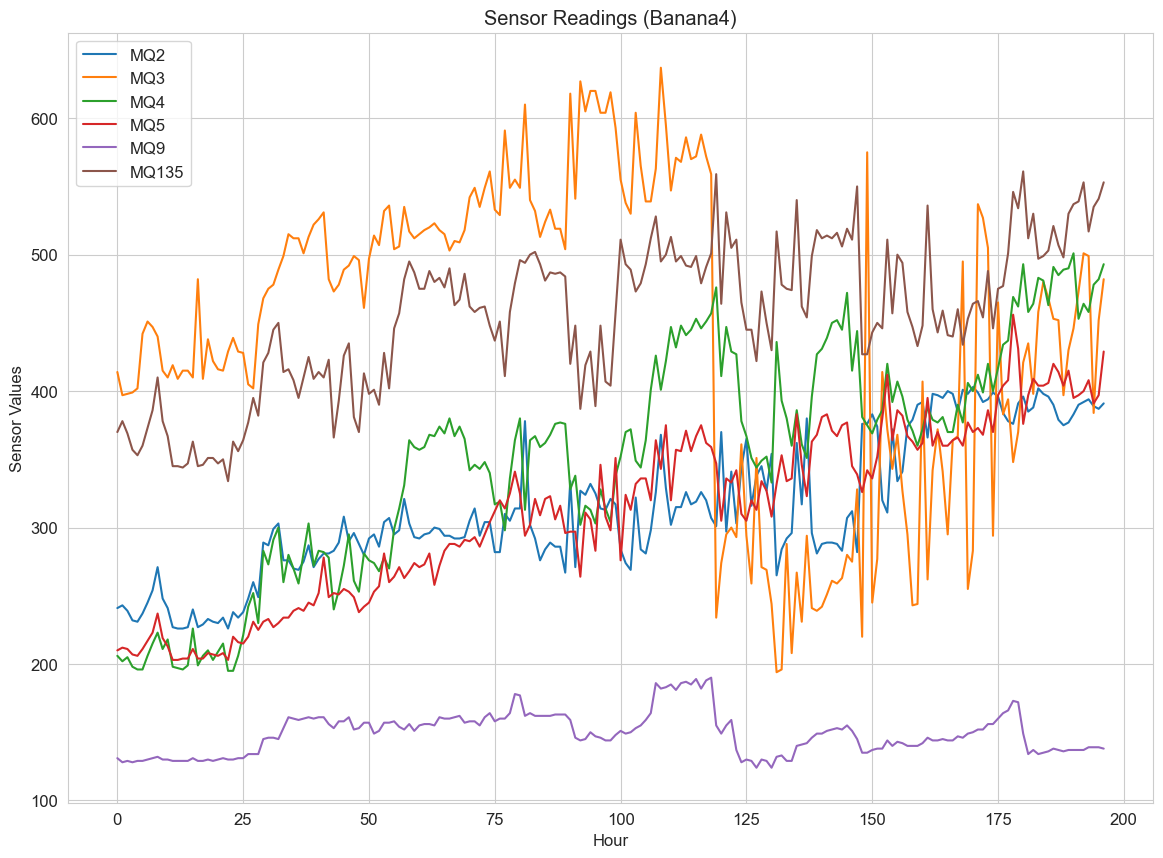

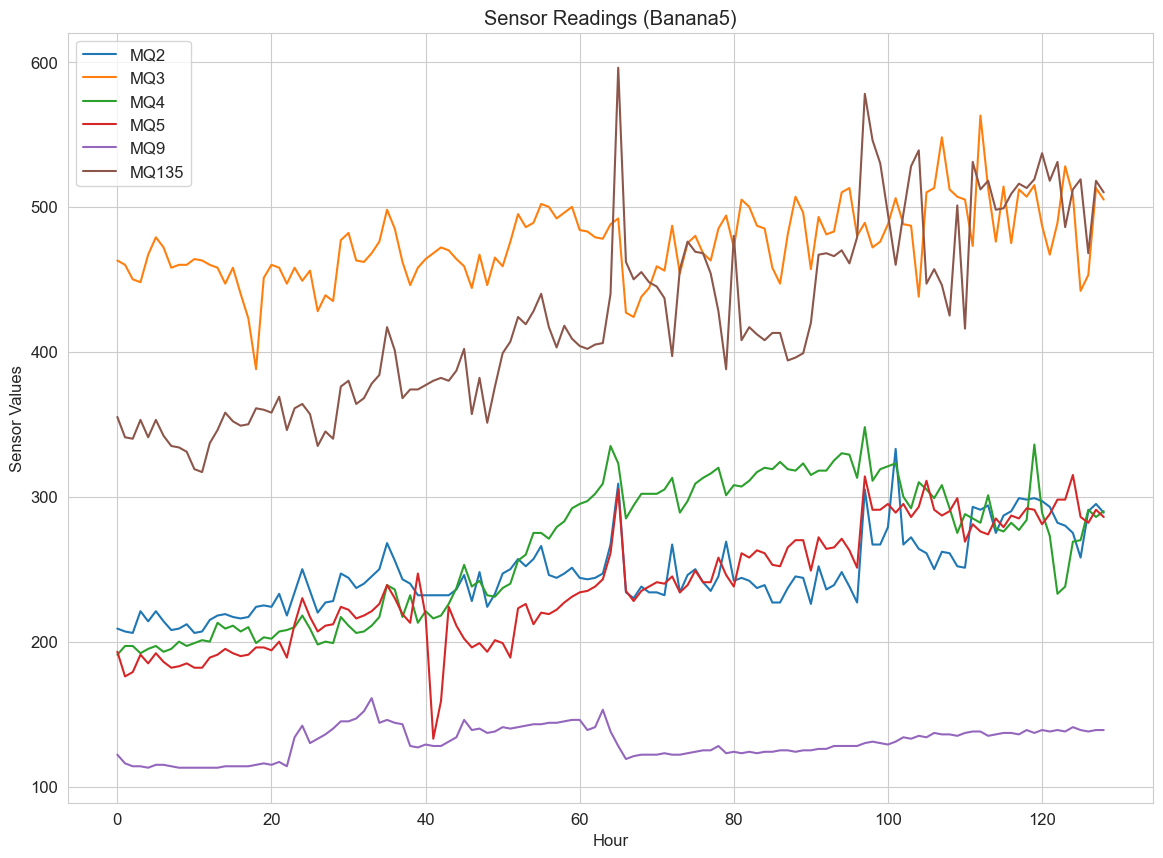

In [16]:
def plot_sensor_readings(df, banana_name):
    sensors = ['MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ9', 'MQ135']
    
    plt.figure(figsize=(14, 10))
    for sensor in sensors:
        plt.plot(df['Hour'], df[sensor], label=sensor)
    
    plt.xlabel("Hour")
    plt.ylabel("Sensor Values")
    plt.title(f"Sensor Readings ({banana_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sensor_readings(df0, "Banana1")
plot_sensor_readings(df1,"Banana2")
plot_sensor_readings(df2,"Banana3")
plot_sensor_readings(df3, "Banana4")
plot_sensor_readings(df4, "Banana5")

In [18]:
def create_advanced_features(df):
    df_base = df.copy()
    sensor_cols = ['Temp', 'Hum', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ9', 'MQ135']
    new_features_list = []
    
    lags = [1, 2, 3, 4, 5]
    for col in sensor_cols:
        for lag in lags:
            new_features_list.append(df_base[col].shift(lag).rename(f'{col}_lag{lag}'))
            
    rolling_windows = [5, 10, 20]
    for col in sensor_cols:
        for window in rolling_windows:
            new_features_list.append(df_base[col].rolling(window=window, min_periods=1, center=True).mean().rename(f'{col}_roll_mean_{window}'))
            new_features_list.append(df_base[col].rolling(window=window, min_periods=1, center=True).std().rename(f'{col}_roll_std_{window}'))
            new_features_list.append(df_base[col].rolling(window=window, min_periods=1, center=True).min().rename(f'{col}_roll_min_{window}'))
            new_features_list.append(df_base[col].rolling(window=window, min_periods=1, center=True).max().rename(f'{col}_roll_max_{window}'))

    for col in sensor_cols:
        new_features_list.append(df_base[col].diff(1).rename(f'{col}_diff1'))
        new_features_list.append(df_base[col].diff(2).rename(f'{col}_diff2'))

    new_features_list.append((df_base['Temp'] * df_base['Hum']).rename('Temp_x_Hum'))
    new_features_list.append((df_base['MQ2'] / (df_base['MQ5'] + 1e-6)).rename('MQ2_div_MQ5'))
    new_features_list.append((df_base['MQ3'] * df_base['MQ135']).rename('MQ3_x_MQ135'))

    new_features_list.append((df_base['Temp'] * df_base['MQ2']).rename('Temp_x_MQ2'))
    new_features_list.append((df_base['Hum'] * df_base['MQ9']).rename('Hum_x_MQ9'))
    new_features_list.append((df_base['MQ4'] * df_base['MQ5']).rename('MQ4_x_MQ5'))
    new_features_list.append((df_base['MQ3'] / (df_base['Temp'] + 1e-6)).rename('MQ3_div_Temp'))
    new_features_list.append((df_base['MQ9'] / (df_base['Hum'] + 1e-6)).rename('MQ9_div_Hum'))
    new_features_list.append((df_base['MQ135'] / (df_base['MQ2'] + 1e-6)).rename('MQ135_div_MQ2'))

    new_features_list.append((df_base['MQ2'] * df_base['MQ2'].shift(1)).rename('MQ2_x_MQ2_lag1'))
    new_features_list.append((df_base['MQ9'] / (df_base['MQ9'].rolling(window=5, min_periods=1, center=True).mean() + 1e-6)).rename('MQ9_div_MQ9_roll_mean_5'))
    new_features_list.append((df_base['Temp'] * df_base['MQ3'].diff(1)).rename('Temp_x_MQ3_diff1'))
        
    if new_features_list:
        engineered_features = pd.concat(new_features_list, axis=1)
    else:
        engineered_features = pd.DataFrame(index=df_base.index)

    df_processed = pd.concat([df_base, engineered_features], axis=1)

    for col in df_processed.columns:
        if df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].interpolate(method='linear').ffill().bfill()
            
    df_processed = df_processed.dropna()
    return df_processed

banana_datasets_fe = []
for df in [df0, df1, df2, df3, df4]:
    banana_datasets_fe.append(create_advanced_features(df))
    
banana_datasets_fe

[     Hour  MQ2  MQ3  MQ4  MQ5  MQ9  MQ135  Temp   Hum  Hours Left to Rot  ...  \
 0       0  165  353  155  210  110    398  32.1  41.8                120  ...   
 1       1  161  383  150  203  108    397  32.1  41.1                119  ...   
 2       2  153  333  150  200  108    406  32.1  41.1                118  ...   
 3       3  171  365  166  205  108    397  32.1  41.1                117  ...   
 4       4  153  344  148  191  106    382  32.1  41.1                116  ...   
 ..    ...  ...  ...  ...  ...  ...    ...   ...   ...                ...  ...   
 142   142  252  419  282  302  151    487  31.2  55.4                  0  ...   
 143   143  261  409  293  297  152    467  31.2  55.4                  0  ...   
 144   144  250  415  305  299  153    448  32.8  54.2                  0  ...   
 145   145  262  415  301  303  152    442  32.9  54.2                  0  ...   
 146   146  261  410  299  297  148    430  33.1  55.3                  0  ...   
 
      MQ3_x_MQ

In [19]:
banana_datasets = banana_datasets_fe

base_features = ['Temp', 'Hum', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ9', 'MQ135']
features = list(base_features)

In [20]:
sample_df = banana_datasets[0]
for col in sample_df.columns:
    if any(f'{original_col}_' in col for original_col in base_features) or \
       col in ['Temp_x_Hum', 'MQ2_div_MQ5', 'MQ3_x_MQ135']:
        if col not in features:
            features.append(col)

if 'Hour' in features:
    features.remove('Hour')

target = 'Hours Left to Rot'

In [21]:
models = {
    'SVR': SVR(kernel='rbf', C=5000, gamma=0.005, epsilon=0.05),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.03, max_depth=7, subsample=0.7, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=400, learning_rate=0.02, max_depth=8, subsample=0.7, colsample_bytree=0.7, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=300, random_state=42, max_depth=15, min_samples_leaf=3, min_samples_split=5),
    'Linear Regression': LinearRegression()
}

In [22]:
final_results = []
all_r2_scores = {name: [] for name in models.keys()}
all_rmse_scores = {name: [] for name in models.keys()}
all_mae_scores = {name: [] for name in models.keys()}
all_mse_scores = {name: [] for name in models.keys()}

all_features_data = pd.concat(banana_datasets, ignore_index=True)
all_features_data = all_features_data[all_features_data[target] > 0].copy()

X_all = all_features_data[features]
y_all = all_features_data[target]

features_to_select_from = [f for f in features if f in X_all.columns]
X_all = X_all[features_to_select_from]

print(f"Total features before selection: {len(features_to_select_from)}")

Total features before selection: 172


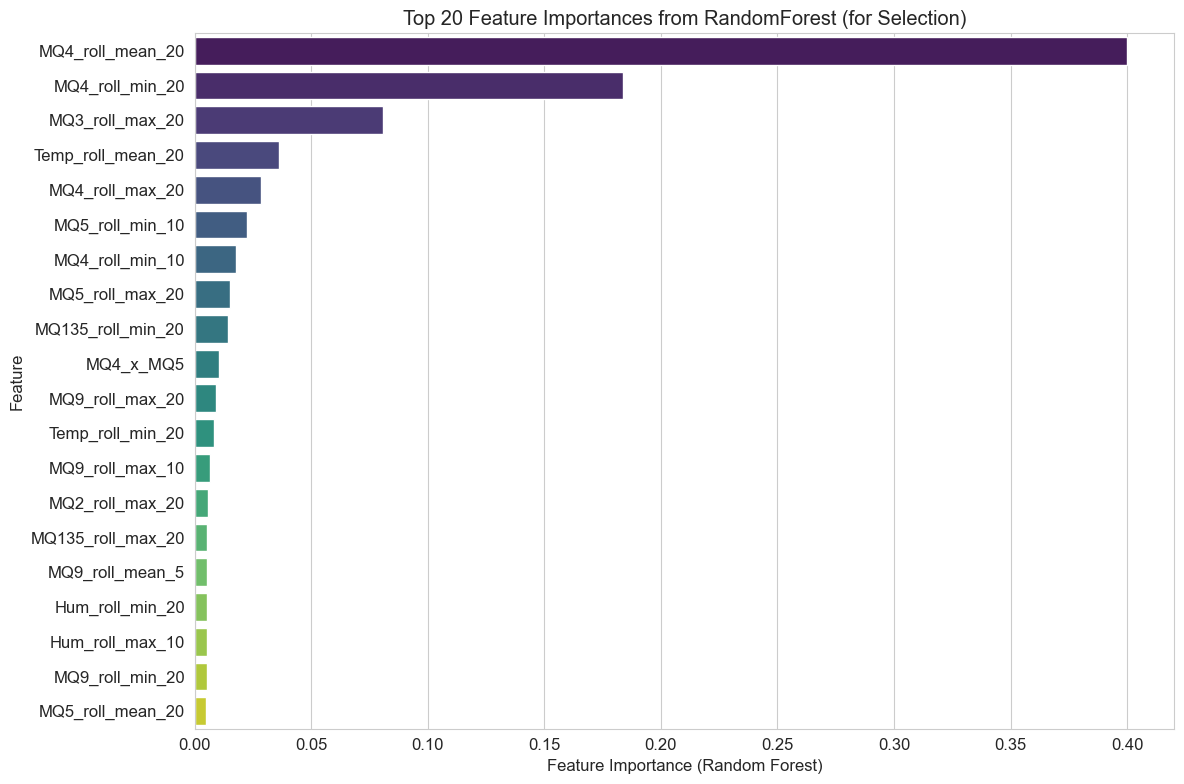

In [23]:
rf_selector = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_selector.fit(X_all, y_all)

feature_importances_rf = pd.Series(rf_selector.feature_importances_, index=X_all.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_rf.head(top_n).values, y=feature_importances_rf.head(top_n).index, palette='viridis')
plt.xlabel("Feature Importance (Random Forest)")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances from RandomForest (for Selection)")
plt.tight_layout()
plt.show()

In [24]:
sfm = SelectFromModel(rf_selector, threshold='median')
sfm.fit(X_all, y_all)

selected_feature_indices = sfm.get_support(indices=True)
selected_features_names = X_all.columns[selected_feature_indices].tolist()

print(f"Selected features after RandomForest selection: {len(selected_features_names)}")
features = selected_features_names

Selected features after RandomForest selection: 86


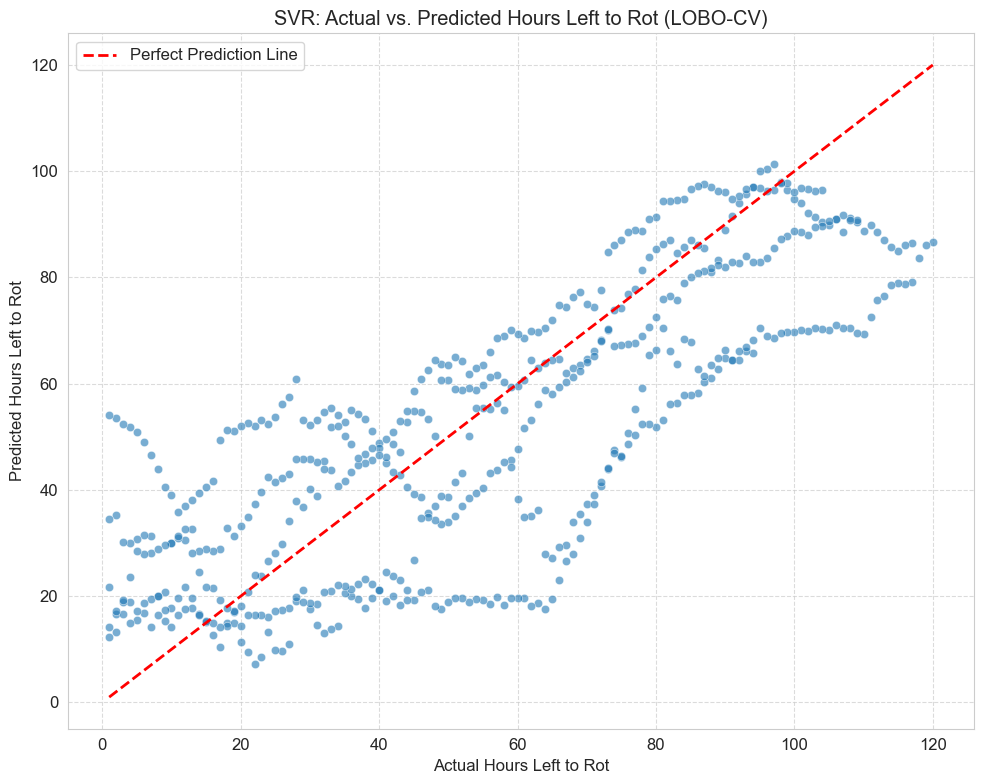

C:\Users\Aryan Prasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


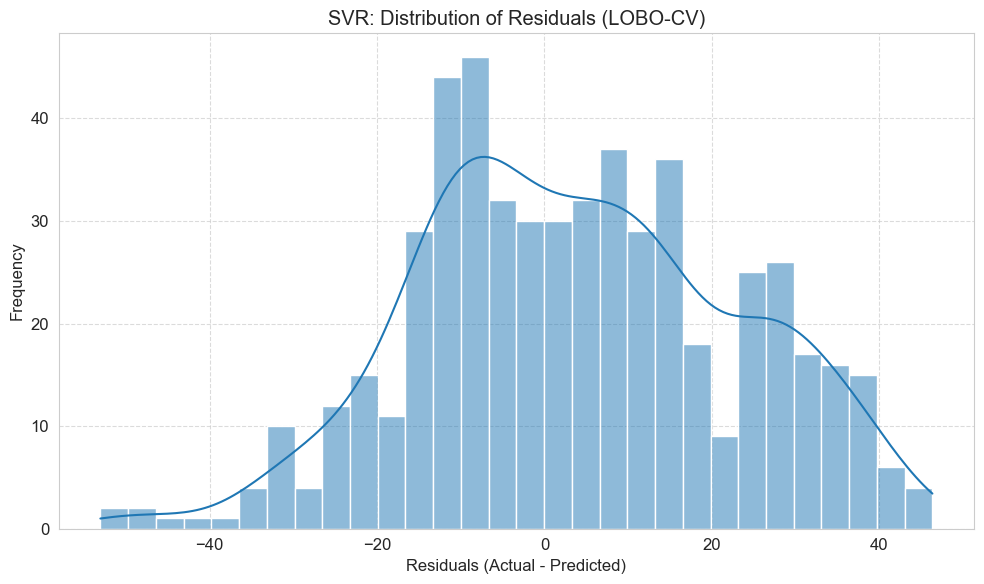

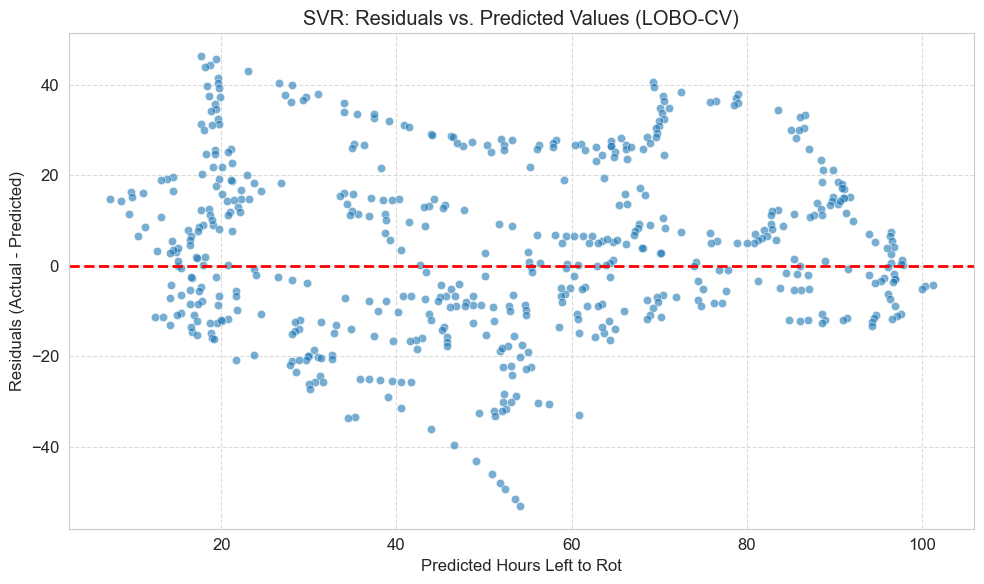

Skipping feature importance plot for SVR as it does not directly provide 'feature_importances_' or coefficients for easy comparison in this context.


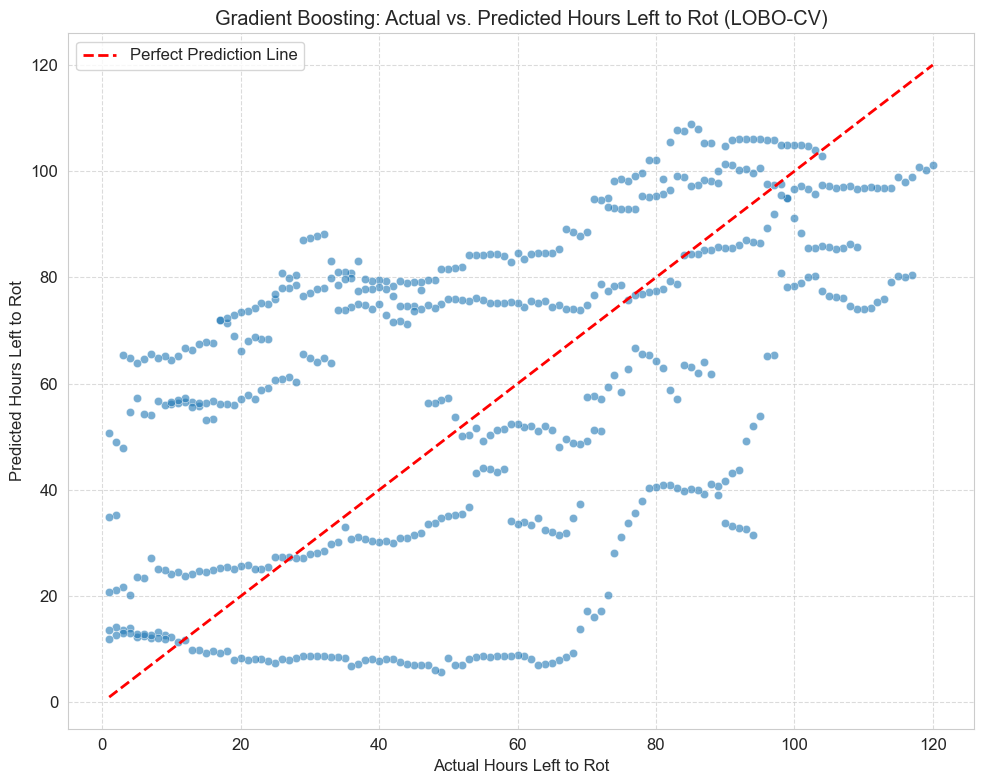

C:\Users\Aryan Prasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


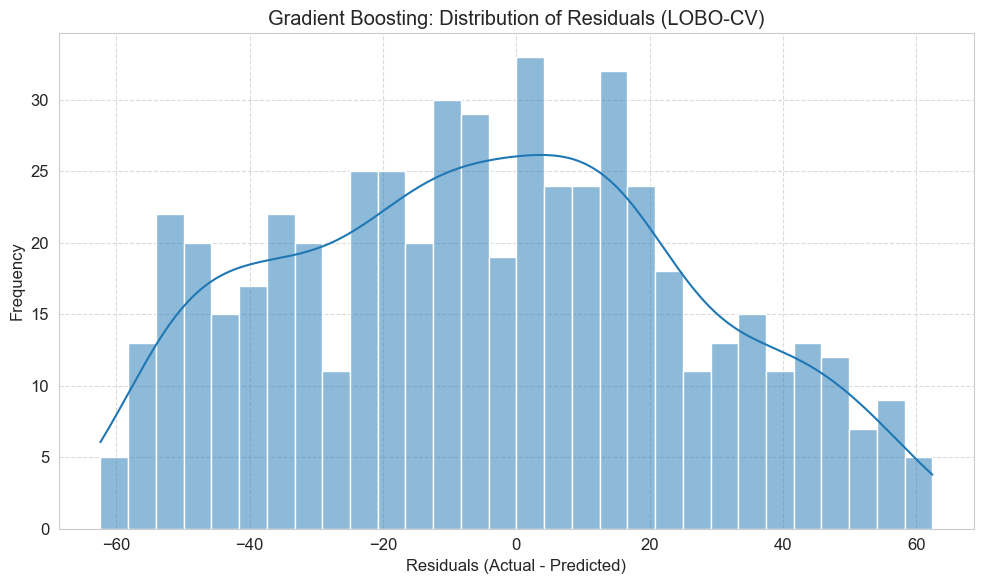

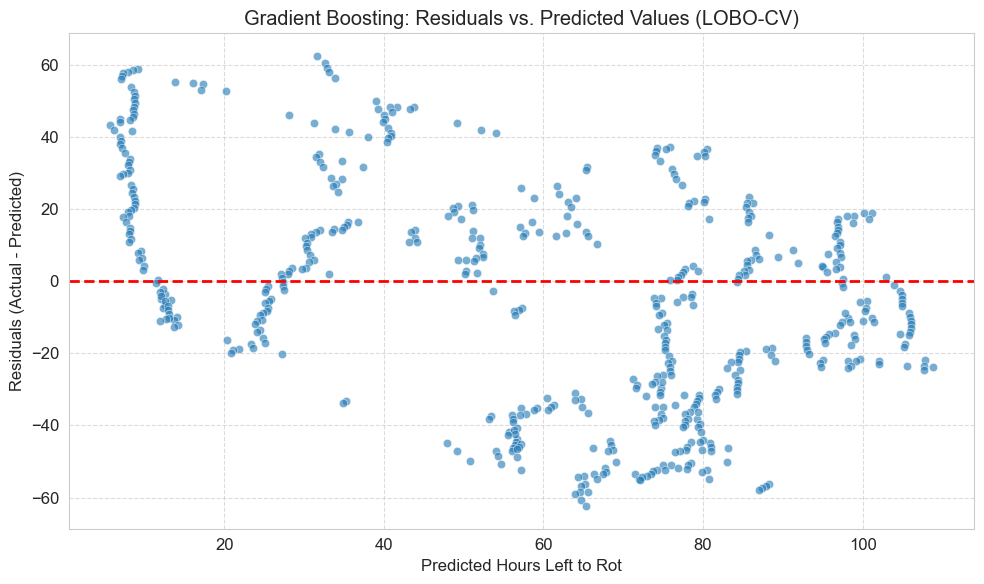

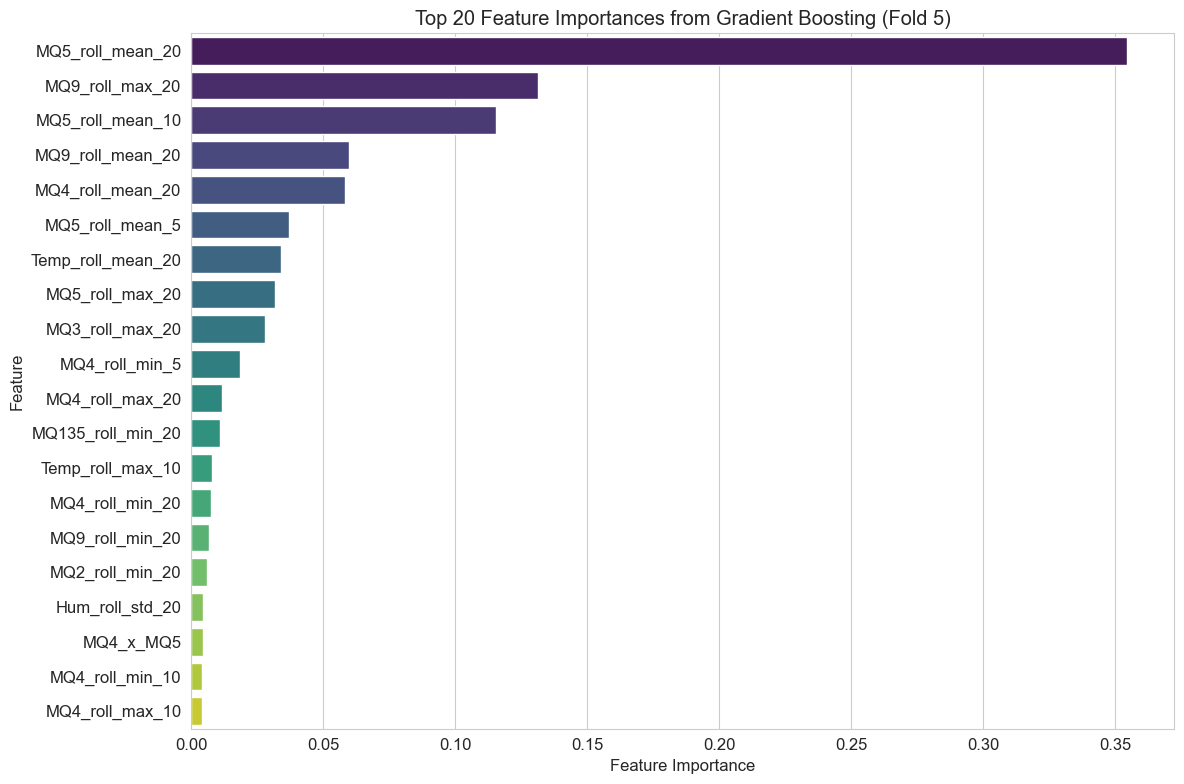

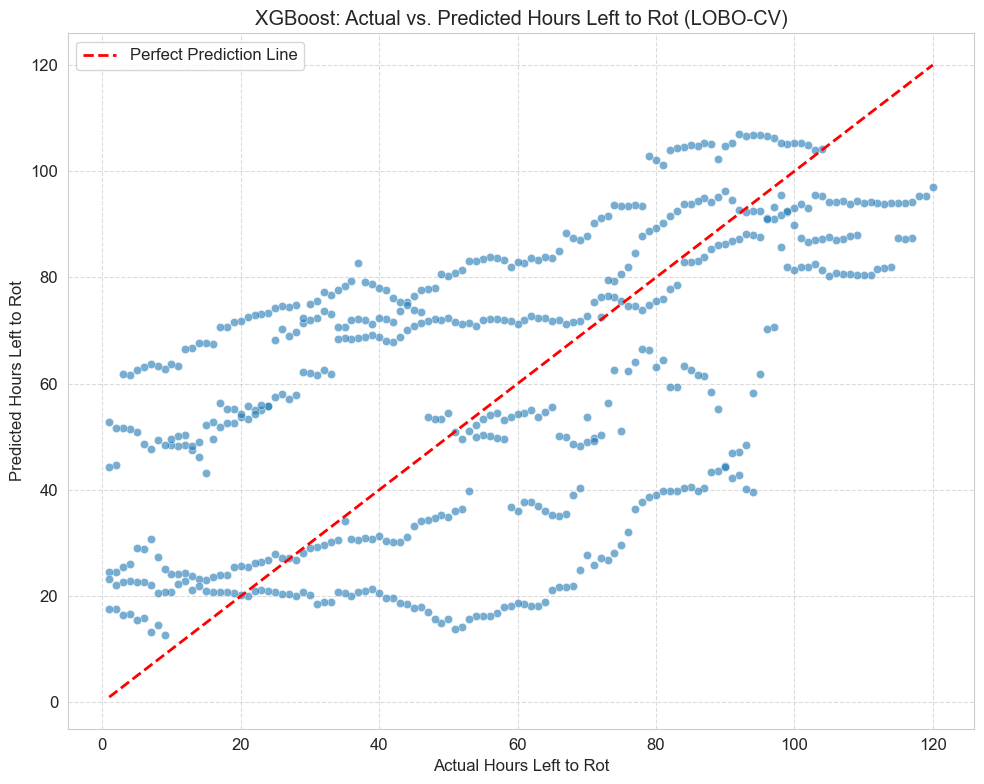

C:\Users\Aryan Prasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


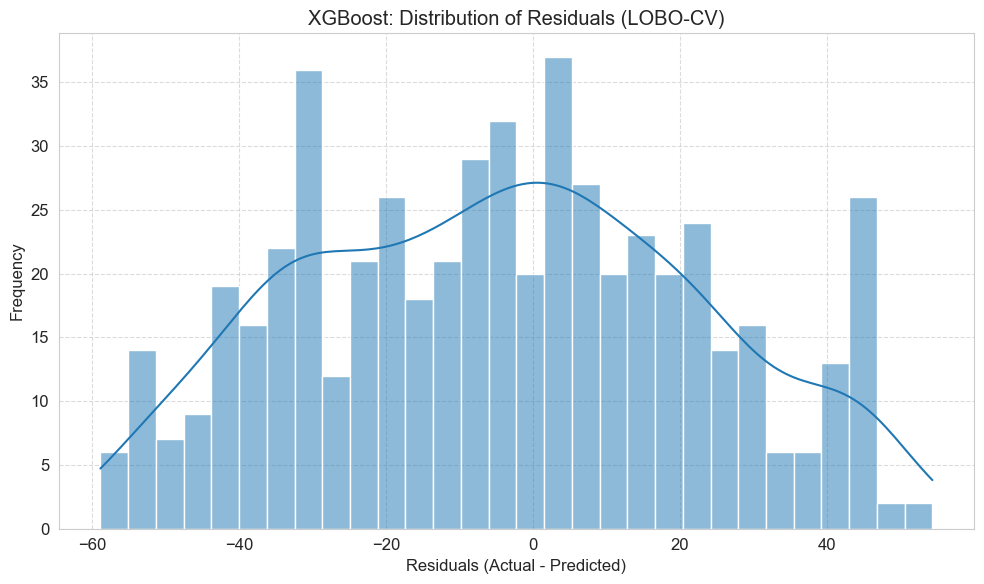

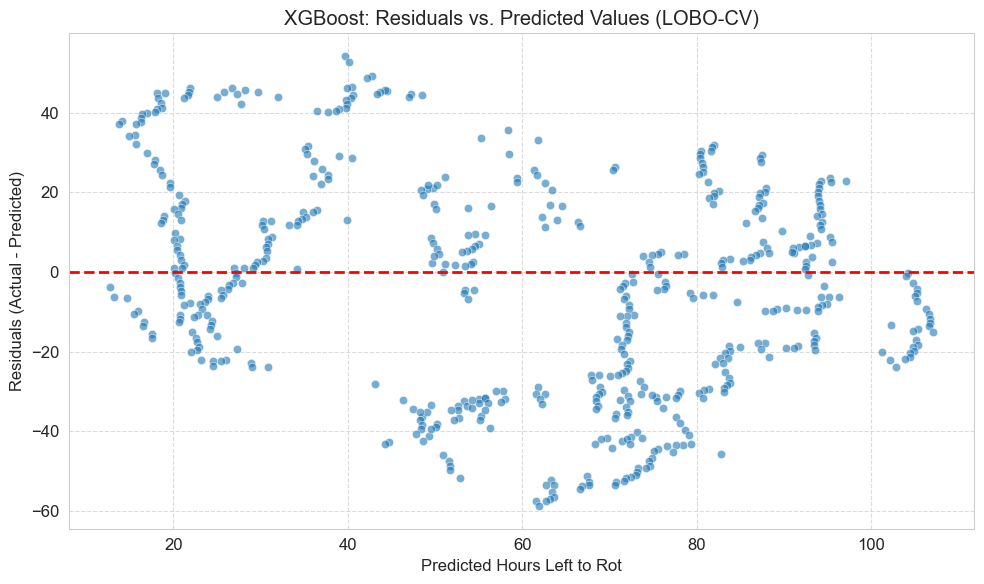

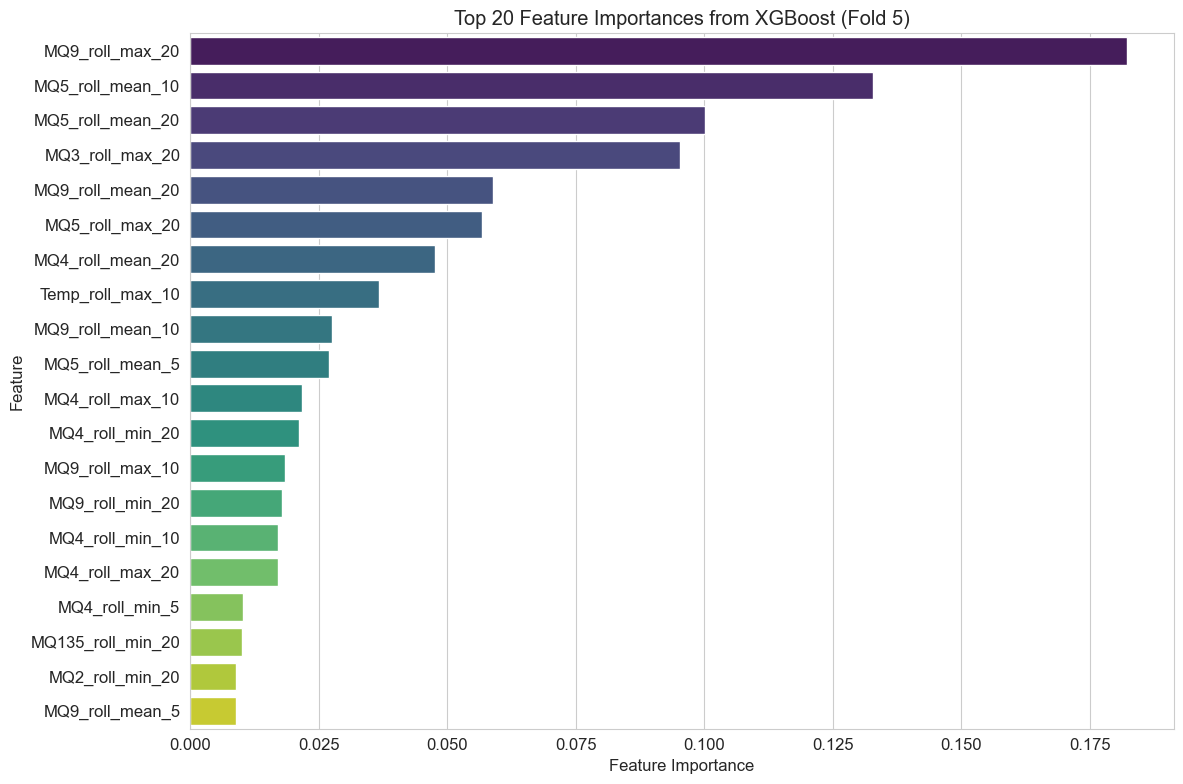

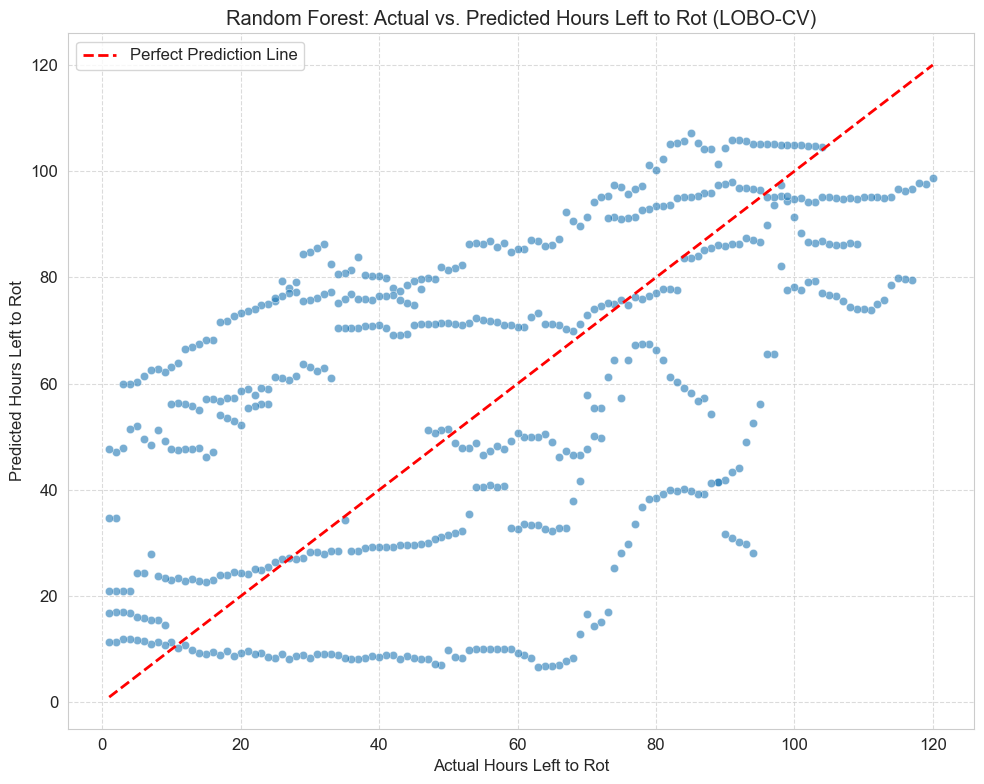

C:\Users\Aryan Prasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


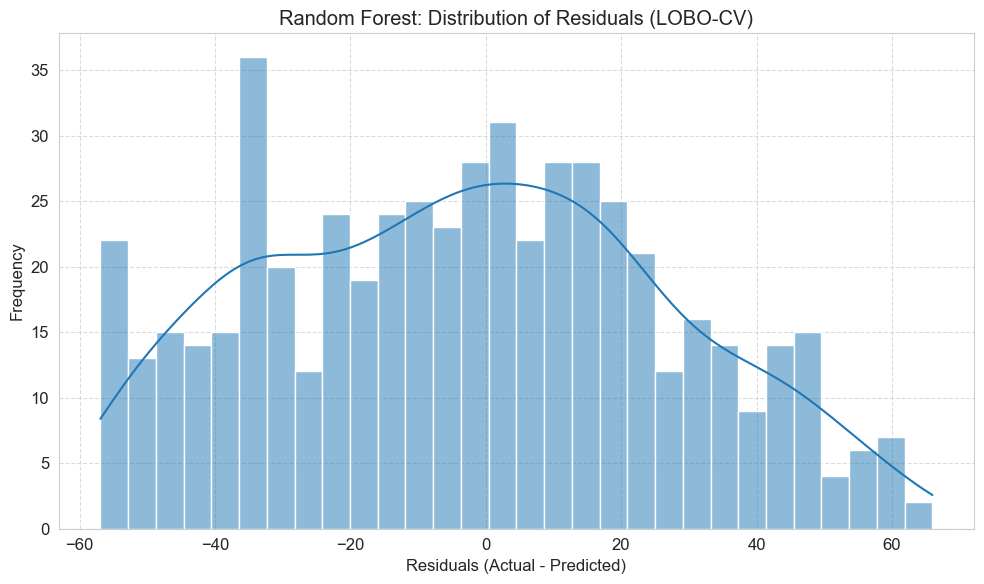

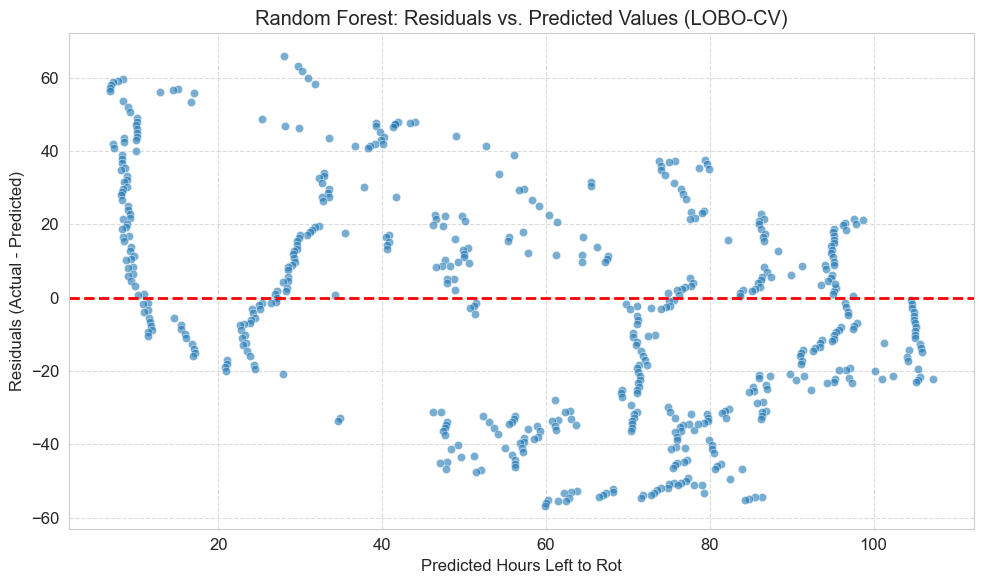

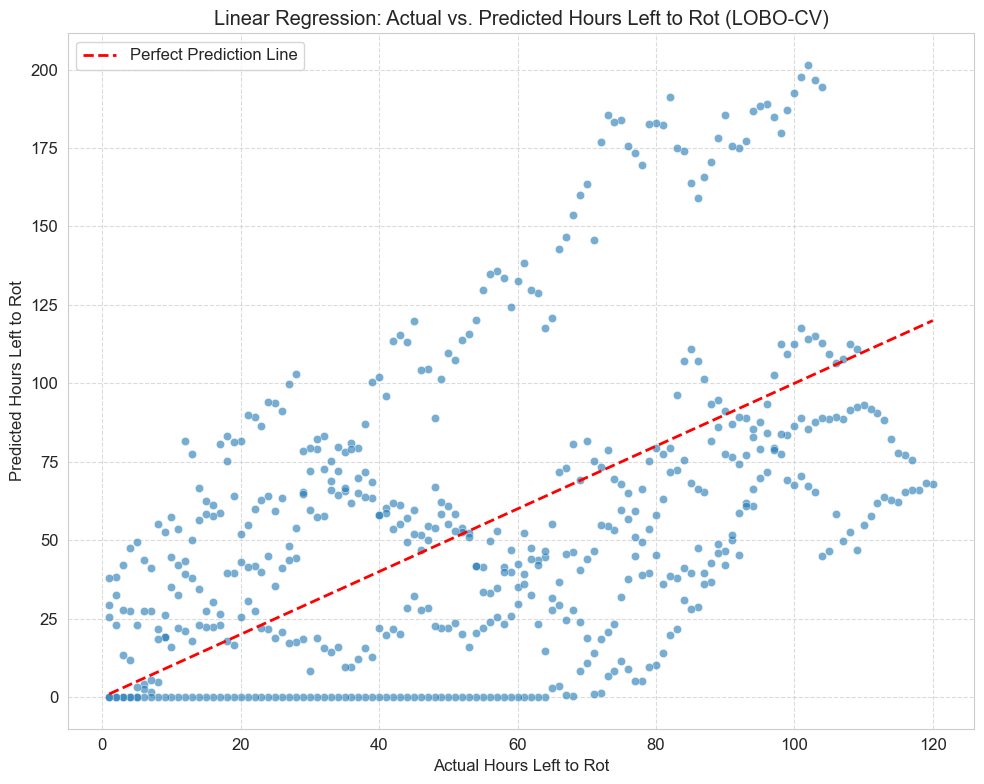

C:\Users\Aryan Prasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


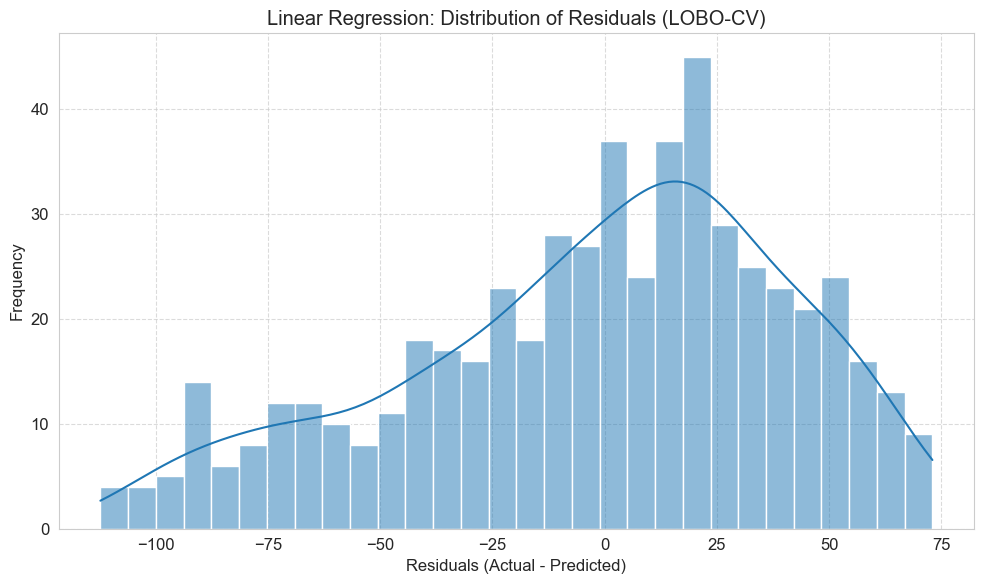

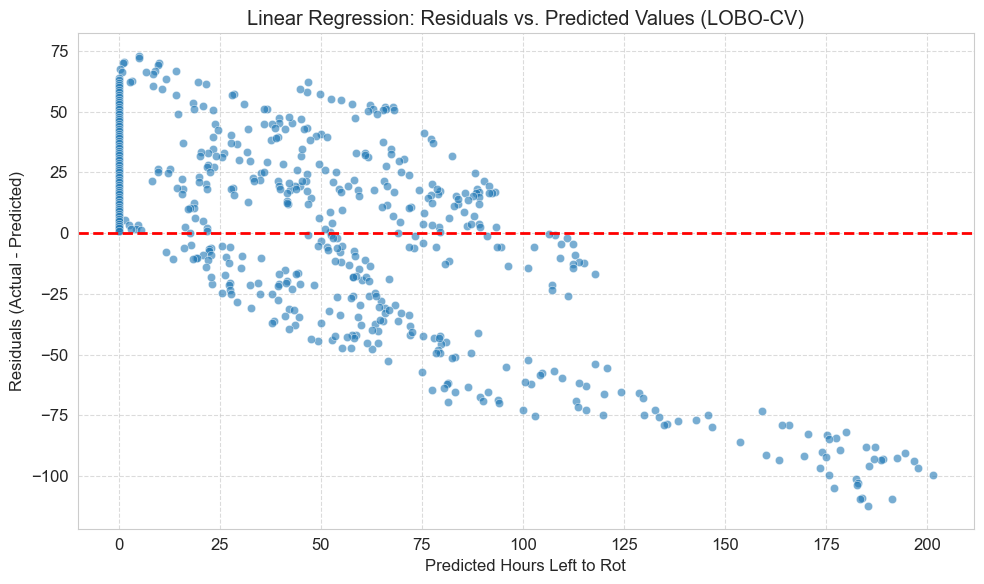

Skipping feature importance plot for Linear Regression as it does not directly provide 'feature_importances_' or coefficients for easy comparison in this context.


In [25]:
for model_name, model in models.items():
    
    overall_y_test = []
    overall_y_pred = []

    for i in range(len(banana_datasets)):
        test_df = banana_datasets[i]
        train_df = pd.concat([banana_datasets[j] for j in range(len(banana_datasets)) if j != i], ignore_index=True)

        train_df = train_df[train_df[target] > 0].copy()
        test_df = test_df[test_df[target] > 0].copy()

        current_features_in_fold = [f for f in features if f in train_df.columns and f in test_df.columns]

        X_train = train_df[current_features_in_fold]
        y_train = train_df[target]
        X_test = test_df[current_features_in_fold]
        y_test = test_df[target]
        
        if X_train.empty or X_test.empty or len(current_features_in_fold) == 0:
            print(f"Skipping fold {i} for {model_name} due to empty data or no features.")
            continue

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        y_pred[y_pred < 0] = 0

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        
        all_r2_scores[model_name].append(r2)
        all_rmse_scores[model_name].append(rmse)
        all_mae_scores[model_name].append(mae)
        all_mse_scores[model_name].append(mse)

        overall_y_test.extend(y_test)
        overall_y_pred.extend(y_pred)
    
    if all_r2_scores[model_name]:
        final_results.append({
            'Model': model_name,
            'Avg R2 Score': np.mean(all_r2_scores[model_name]),
            'Avg RMSE': np.mean(all_rmse_scores[model_name]),
            'Avg MAE': np.mean(all_mae_scores[model_name]),
            'Avg MSE': np.mean(all_mse_scores[model_name])
        })
        
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=overall_y_test, y=overall_y_pred, alpha=0.6)
        plt.plot([min(overall_y_test), max(overall_y_test)], [min(overall_y_test), max(overall_y_test)], color='red', linestyle='--', lw=2, label='Perfect Prediction Line')
        plt.xlabel("Actual Hours Left to Rot")
        plt.ylabel("Predicted Hours Left to Rot")
        plt.title(f"{model_name}: Actual vs. Predicted Hours Left to Rot (LOBO-CV)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

        residuals = np.array(overall_y_test) - np.array(overall_y_pred)
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, bins=30)
        plt.xlabel("Residuals (Actual - Predicted)")
        plt.ylabel("Frequency")
        plt.title(f"{model_name}: Distribution of Residuals (LOBO-CV)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=overall_y_pred, y=residuals, alpha=0.6)
        plt.axhline(y=0, color='red', linestyle='--', lw=2)
        plt.xlabel("Predicted Hours Left to Rot")
        plt.ylabel("Residuals (Actual - Predicted)")
        plt.title(f"{model_name}: Residuals vs. Predicted Values (LOBO-CV)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        if model_name in ['XGBoost', 'Gradient Boosting']:
            if hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
                model_feature_importances = pipeline.named_steps['regressor'].feature_importances_
                
                feature_importances_series = pd.Series(model_feature_importances, index=X_train.columns)
                feature_importances_series = feature_importances_series.sort_values(ascending=False)

                plot_n = min(top_n, len(feature_importances_series)) 
                
                if plot_n > 0:
                    plt.figure(figsize=(12, 8))
                    sns.barplot(x=feature_importances_series.head(plot_n).values, 
                                y=feature_importances_series.head(plot_n).index, 
                                palette='viridis')
                    plt.xlabel("Feature Importance")
                    plt.ylabel("Feature")
                    plt.title(f"Top {plot_n} Feature Importances from {model_name} (Fold {i+1})")
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"No features to plot for {model_name} feature importance in Fold {i+1}.")
            else:
                print(f"{model_name} does not have 'feature_importances_'.")
        elif model_name == 'SVR' or model_name == 'Linear Regression':
            print(f"Skipping feature importance plot for {model_name} as it does not directly provide 'feature_importances_' or coefficients for easy comparison in this context.")

    else:
        print(f"No results recorded for {model_name}.")


In [26]:
results_df = pd.DataFrame(final_results).sort_values(by='Avg R2 Score', ascending=False)
print("\nLOBO Cross-Validation Results (Leave-One-Banana-Out) with Advanced Features & Visualizations:")
print(results_df)


LOBO Cross-Validation Results (Leave-One-Banana-Out) with Advanced Features & Visualizations:
               Model  Avg R2 Score   Avg RMSE    Avg MAE      Avg MSE
0                SVR      0.621069  18.103699  15.701843   372.257489
2            XGBoost      0.259096  26.481008  22.394082   731.491455
3      Random Forest      0.117597  28.985356  24.543232   875.429083
1  Gradient Boosting      0.081897  29.678173  25.111625   917.289309
4  Linear Regression     -0.931454  39.253168  34.575776  1849.721773


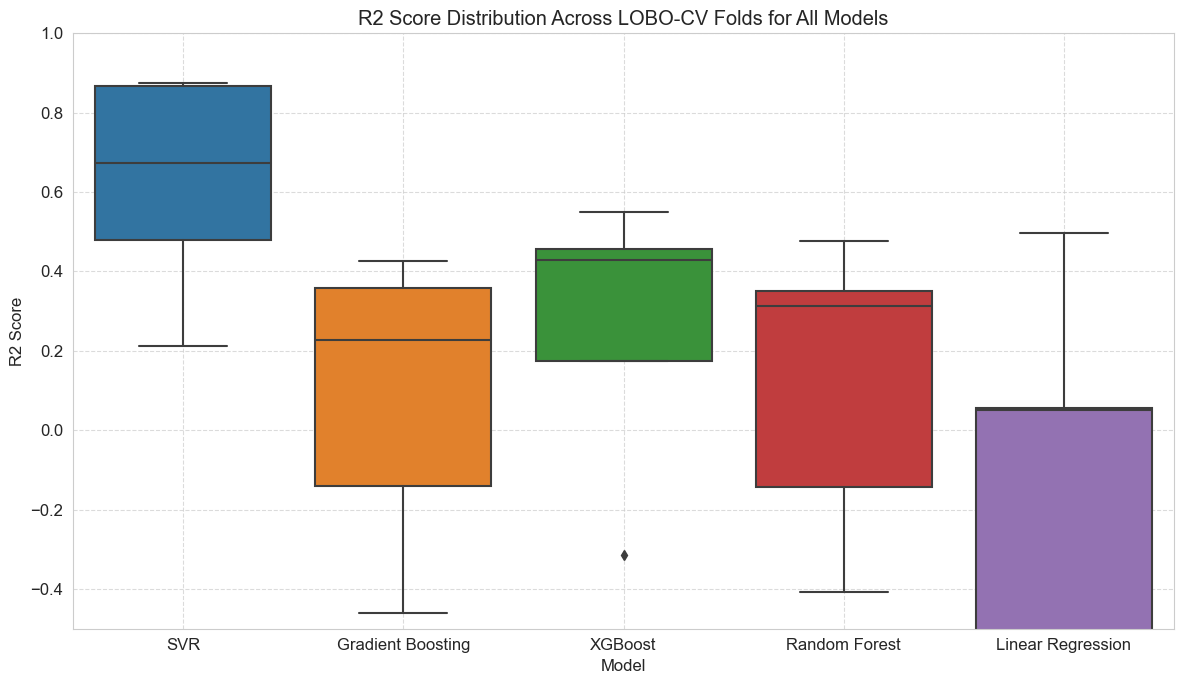

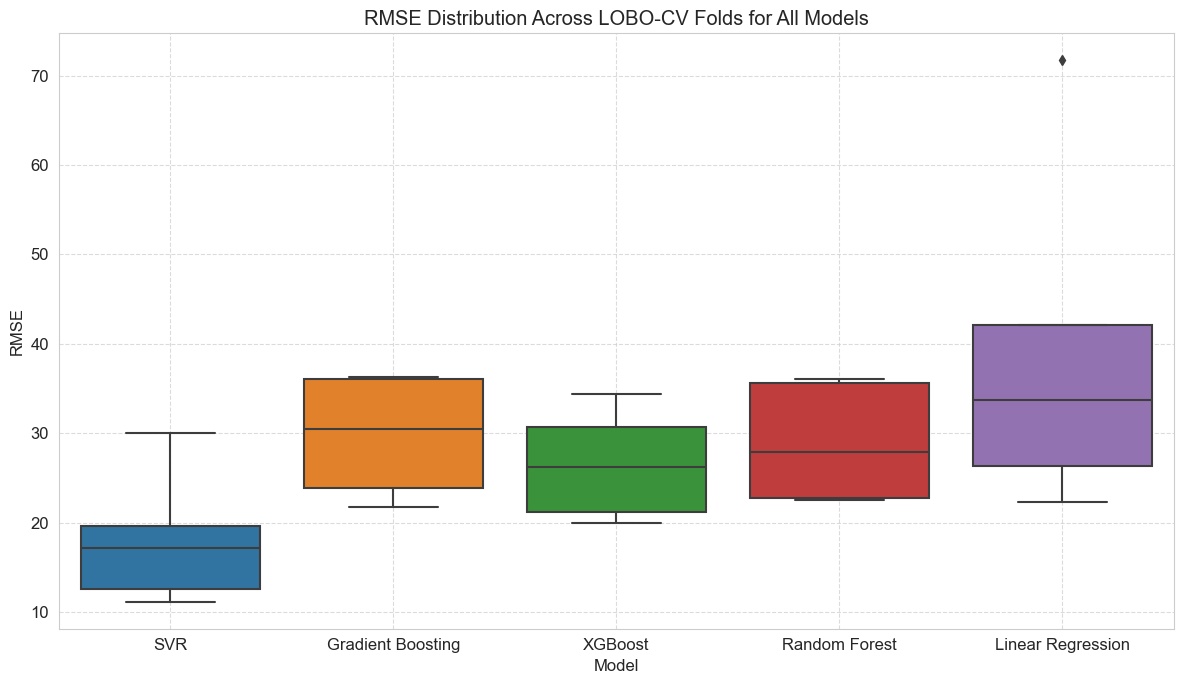

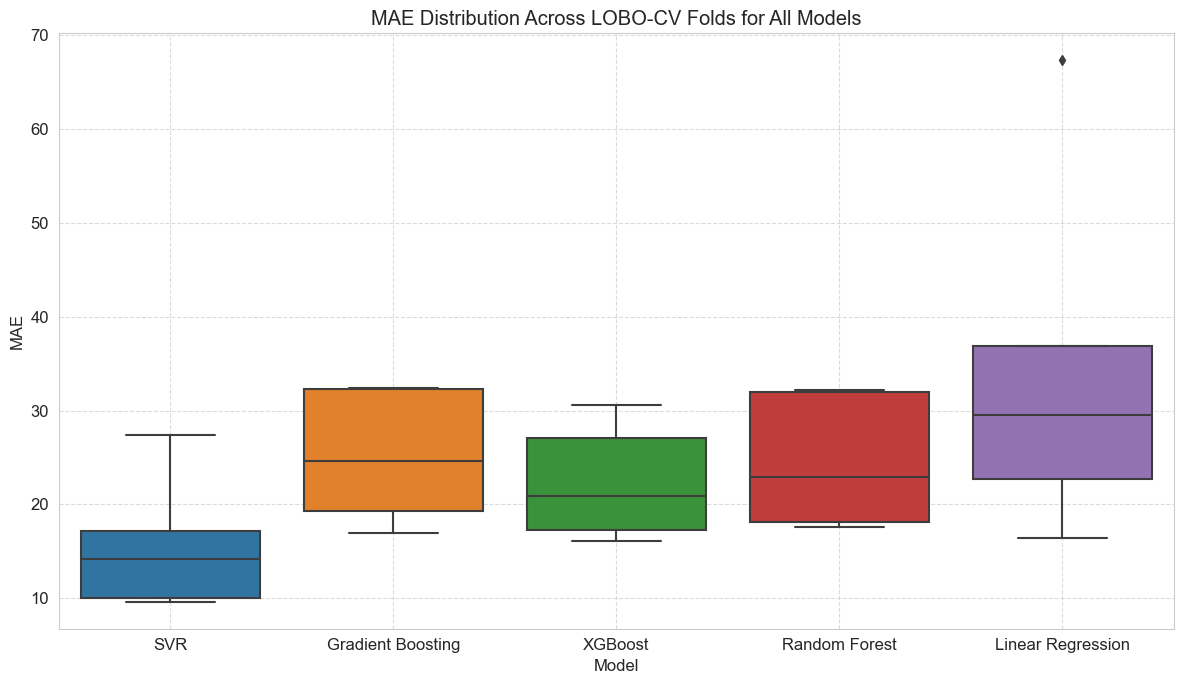

In [27]:
r2_df = pd.DataFrame(all_r2_scores)
plt.figure(figsize=(12, 7))
sns.boxplot(data=r2_df)
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.title("R2 Score Distribution Across LOBO-CV Folds for All Models")
plt.ylim(-0.5, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

rmse_df = pd.DataFrame(all_rmse_scores)
plt.figure(figsize=(12, 7))
sns.boxplot(data=rmse_df)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Distribution Across LOBO-CV Folds for All Models")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

mae_df = pd.DataFrame(all_mae_scores)
plt.figure(figsize=(12, 7))
sns.boxplot(data=mae_df)
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("MAE Distribution Across LOBO-CV Folds for All Models")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()